# Práctica 1

### Resolución de problemas de clasificación y análisis experimental

*Alejandro Alonso Membrilla*

El primer paso es leer los datos a analizar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
raw_data=pd.read_csv("mamografias.csv",na_values=["?", "N"])

Y observar rápidamente la forma que tienen los datos:

In [2]:
raw_data.head(100)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,L,5.0,3.0,maligno
1,4.0,43.0,R,1.0,NaN,maligno
2,5.0,58.0,I,5.0,3.0,maligno
3,4.0,28.0,R,1.0,3.0,benigno
4,5.0,74.0,R,5.0,NaN,maligno
...,...,...,...,...,...,...
95,5.0,54.0,I,4.0,3.0,maligno
96,4.0,40.0,R,1.0,NaN,benigno
97,4.0,47.0,O,1.0,NaN,benigno
98,5.0,62.0,I,4.0,3.0,benigno


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   Age       956 non-null    float64
 2   Shape     930 non-null    object 
 3   Margin    913 non-null    float64
 4   Density   885 non-null    float64
 5   Severity  961 non-null    object 
dtypes: float64(4), object(2)
memory usage: 45.2+ KB


In [4]:
raw_data.describe()

,BI-RADS,Age,Margin,Density
count,959.000000,956.000000,913.000000,885.000000
mean,4.296142,55.487448,2.796276,2.910734
std,0.706291,14.480131,1.566546,0.380444
min,0.000000,18.000000,1.000000,1.000000
25%,4.000000,45.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,3.000000
max,6.000000,96.000000,5.000000,4.000000


In [5]:
raw_data['Shape'].count()

930

A excepción de la edad, los estadísticos calculados no tienen sentido para las variables medidas (BI-RADS, Margin y Density son cuantitativas). Sí tiene algo de interés el número de elementos de cada clase (nos informa de los datos perdidos) y los cuantiles. 

Le cambiamos el nombre a las columnas para que sean más sencillas de manipular.

In [6]:
raw_data.columns = [col.lower() for col in raw_data]

## 1. Preprocesamiento de los Datos

Transformamos los atributos de tipo cadena en valores numéricos:  

In [7]:
from sklearn import preprocessing

le=preprocessing.LabelEncoder()

data=raw_data.copy()

#Codificamos la columna de la forma del tumor (necesario para la sustitución de valores perdidos)
indices = pd.notnull(data['shape'])
data.loc[indices, ('shape')] = le.fit_transform(raw_data.loc[indices, ('shape')])

In [8]:
data.describe()

,bi-rads,age,margin,density
count,959.000000,956.000000,913.000000,885.000000
mean,4.296142,55.487448,2.796276,2.910734
std,0.706291,14.480131,1.566546,0.380444
min,0.000000,18.000000,1.000000,1.000000
25%,4.000000,45.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,3.000000
max,6.000000,96.000000,5.000000,4.000000


### Valores perdidos

Antes de entrenar modelos de predicción usando nuestro conjunto de datos es importante eliminar/sustituir los valores perdidos para poder pasar a los algoritmos de aprendizaje valores numéricos con los que este pueda trabajar.

Si una columna está formada mayoritariamente por valores perdidos, esta se puede eliminar. La columna con más pérdidas en nuestro caso es "Density" con 76 pérdidas, menos de un 10%, lo que no es suficiente para eliminarla. Por otro lado, tampoco parece conveniente eliminar 76 filas completas de la tabla. Intentaremos, por tanto, sustituir estos valores de la forma más insesgada que encontremos.

Sustituir los valores perdidos por la moda de su respectiva columna es realizable en columnas como BI-RADS y Age con ínfimas pérdidas. Para el resto de columnas, puede suponer un sesgo que es mejor evitar.

Probaremos con el IterativeImputer de Scikit-Learn:

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

Este método utliza valores flotantes, por lo que redondearemos el resultado para obtener un resultado válido en aquellas columnas que solo acepten valores enteros (todas).


In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [10]:
imp = IterativeImputer(random_state=0, initial_strategy='most_frequent')
values = imp.fit_transform(data.values[:,0:5])
values = values.astype(int)

In [11]:
data = pd.DataFrame(values)
data.columns = raw_data.columns[0:5]
data = data.join(raw_data['severity'])
data

,bi-rads,age,shape,margin,density,severity
0,5,67,1,5,3,maligno
1,4,43,3,1,2,maligno
2,5,58,0,5,3,maligno
3,4,28,3,1,3,benigno
4,5,74,3,5,2,maligno
...,...,...,...,...,...,...
956,4,47,2,1,3,benigno
957,4,56,0,5,3,maligno
958,4,64,0,5,3,benigno
959,5,66,0,5,3,maligno


###Búsqueda de outliers

Como estamos trabajando con datos categórigos, no podemos buscar outliers por el procedimiento estándar.

###Valores a predecir (severidad del tumor)

Saber cuántos hay de cada uno nos permitirá intuir cuan buenos son nuestros modelos y nos será útil, en general, en la fase de análisis de resultados. Vamos a consultar esto en los datos originales (con etiquetas sin codificar)

In [12]:
data['severity'].describe()

count         961
unique          2
top       benigno
freq          516
Name: severity, dtype: object

Vemos que hay 961 tumores en total, de los cuales 516 (un 53.69%) son benignos. Esto implicará que, si asumimos que todos los tumores son benignos acertaremos un 53.69% de las veces. Este umbral a superar es bastante bajo, por lo que no debería ser difícil obtener resultados mejores.

### Dependencia

Vamos a generar un histograma que muestre la cantidad de tumores malignos y benignos encontrados en función del tipo de diagnóstico (BI-RAD).

In [13]:
import seaborn as sns

In [14]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

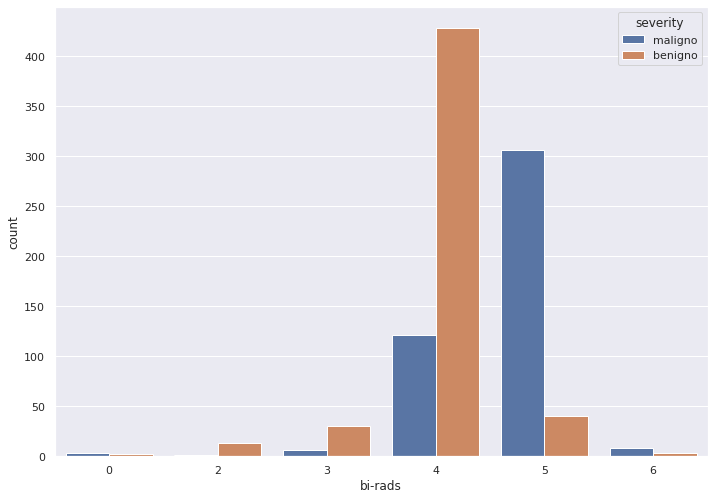

In [15]:
sns.countplot('bi-rads', data=data, hue='severity')

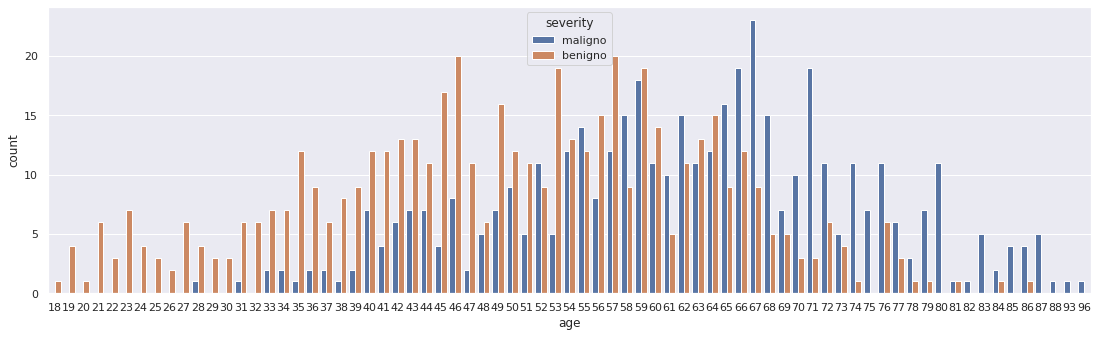

In [16]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(18.7,5.27)})
sns.countplot('age', data=data, hue='severity')

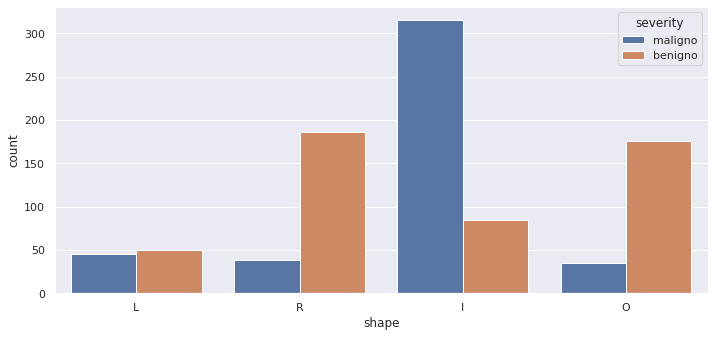

In [17]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,5.27)})
#La columna 'shape' de data está codificada. La descodificamos
data['shape'] = le.inverse_transform( data['shape'] )
sns.countplot('shape', data=raw_data, hue='severity')

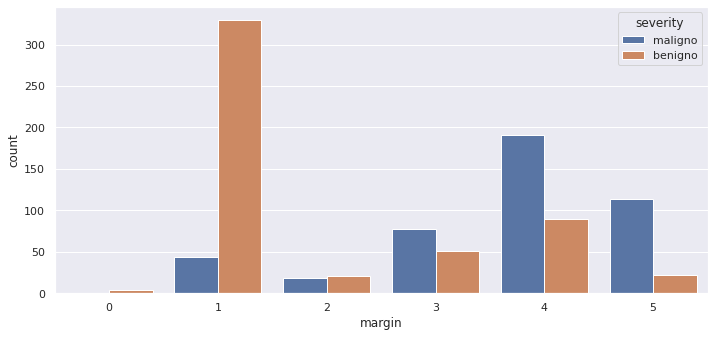

In [18]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,5.27)})
sns.countplot('margin', data=data, hue='severity')

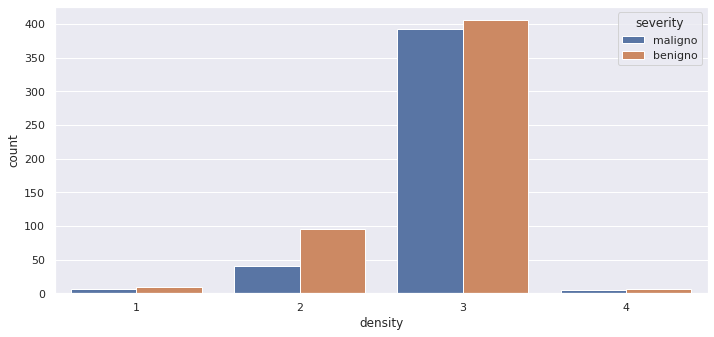

In [19]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,5.27)})
sns.countplot('density', data=data, hue='severity')

###Análisis de componentes principales

Queremos ver si podemos considerar alguna de las variables como redundante. Usaremos el módulo para PCA (Principal Components Analysis) de Scikit-Learn:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
data['severity']=le.fit_transform(raw_data['severity'])
#Volvemos a codificar la columna de la forma del tumor (necesario para entrenar los modelos)
indices = pd.notnull(data['shape'])
le.fit( list(raw_data.loc[indices, ('shape')]) )
data['shape'] = le.transform(data['shape'])

In [22]:
pca = PCA()
pca.fit(data.values[:,0:5])
print("Componentes\n", pca.components_)
print("\nPeso por componente\n", pca.explained_variance_ratio_)
print("\nDatos originales\n", data)
print("\nDatos en componentes principales\n", pca.transform(data.values[:,0:5])[:,0:2])

Componentes
 [[ 1.41921959e-02  9.98420612e-01 -3.13144990e-02  4.43629324e-02
   2.48921260e-03]
 [-1.60104721e-01  5.59142239e-02  5.87505733e-01 -7.90343090e-01
  -3.78799584e-02]
 [ 3.47975946e-03 -1.36866919e-03  8.03115242e-01  5.93930777e-01
   4.73091746e-02]
 [-9.84458643e-01  5.29213941e-03 -9.16012541e-02  1.34831925e-01
  -6.51362930e-02]
 [ 7.06691753e-02 -4.23764508e-05  2.17148274e-02  4.95612171e-02
  -9.96031133e-01]]

Peso por componente
 [9.81290006e-01 1.38315225e-02 2.16787483e-03 1.83408888e-03
 8.76507512e-04]

Datos originales
      bi-rads  age  shape  margin  density  severity
0          5   67      1       5        3         1
1          4   43      3       1        2         1
2          5   58      0       5        3         1
3          4   28      3       1        3         0
4          5   74      3       5        2         1
..       ...  ...    ...     ...      ...       ...
956        4   47      2       1        3         0
957        4   56      0  

Vemos que basta con tomar las dos primeras componentes (explican más del 99% de la información del dataset).

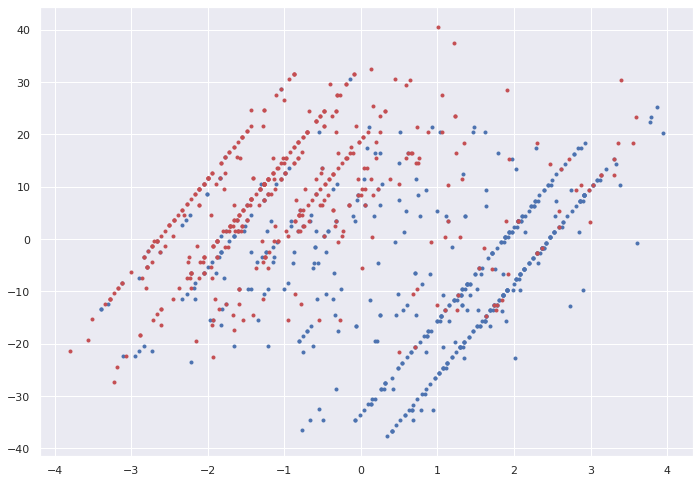

In [23]:
t_data = pca.transform(data.values[:,0:5])[:,0:2]
#Separamos los tumores benignos con coordenadas en este espacio de dimensión reducida...
x_b = [d[1] for i,d in enumerate(t_data) if raw_data.values[i,5]=='benigno']
y_b = [d[0] for i,d in enumerate(t_data) if raw_data.values[i,5]=='benigno']
#... de los tumores malignos...
x_m = [d[1] for i,d in enumerate(t_data) if raw_data.values[i,5]=='maligno']
y_m = [d[0] for i,d in enumerate(t_data) if raw_data.values[i,5]=='maligno']
#... y los visualizamos
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(x_b, y_b, 'b.', x_m, y_m, 'r.')

Observamos una separación relativamente clara de ambas clases, pero también que existe una superposición de ambas que será muy difícil de eliminar.

### Análisis Factorial
Queremos ver si podemos reducir la dimensión del dataset con análisis factorial.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis

In [24]:
from sklearn.decomposition import FactorAnalysis

In [25]:
fa = FactorAnalysis()
fa.fit(data.values[:,0:5])
print("Componentes\n", fa.components_)
print("\Varianza por componente\n", fa.noise_variance_)
print("\nDatos originales\n", data)
print("\nDatos factorizados\n", fa.transform(data.values[:,0:5])[:,0:5])

Componentes
 [[ 2.05978836e-01  1.44040696e+01 -4.54660561e-01  6.43547466e-01
   3.62281948e-02]
 [-2.70518156e-01  1.18635381e-01  8.91053849e-01 -1.15504088e+00
  -6.99253995e-02]
 [-3.63024716e-02  3.92037235e-04 -2.20499242e-02  8.09453361e-03
  -4.82660106e-02]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00]]
\Varianza por componente
 [0.40561672 0.99998193 0.64752389 0.79716145 0.18946366]

Datos originales
      bi-rads  age  shape  margin  density  severity
0          5   67      1       5        3         1
1          4   43      3       1        2         1
2          5   58      0       5        3         1
3          4   28      3       1        3         0
4          5   74      3       5        2         1
..       ...  ...    ...     ...      ...       ...
956        4   47      2       1        3         0
957        4   56      0       5        3  

In [26]:
f_data = fa.transform(data.values[:,0:5])
f_data

array([[ 8.01533912e-01, -6.76219698e-01, -6.69494075e-02,
         0.00000000e+00,  0.00000000e+00],
       [-8.74607590e-01,  9.58867379e-01,  1.55525869e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 1.85881748e-01, -1.26937409e+00, -3.69169985e-02,
         0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.96126893e-01, -9.34729568e-01,  5.34546015e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 7.36108261e-01, -1.03901334e+00, -3.38311836e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 4.47508162e-01,  4.50385084e-02, -8.01942621e-04,
         0.00000000e+00,  0.00000000e+00]])

###Selección de características

Tratamos de encontrar las mejores cararcterísticas aplicando tests estadísticos univariables. Usamos el módulo SelectKBest de Scikit-Learn con el test de $\chi^2$.

In [27]:
from sklearn.feature_selection import SelectKBest

Método de $\chi^2$

In [28]:
from sklearn.feature_selection import chi2
charact = data.values[:,0:5]
label = data.values[:,5]
reducer = SelectKBest(chi2, k='all').fit(charact, label)

In [29]:
reducer.scores_

array([ 28.32051067, 674.99567216, 353.2295735 , 276.67370836,
         0.7646782 ])

El selector de características de Scikit nos dice que la propiedad Density cuenta con una puntuación como característica muy baja. El código BI-RADS tampoco tiene una puntuación muy alta. Tendremos esto en cuenta en la fase de entrenamiento de los modelos.



In [30]:
reducer = SelectKBest(chi2, k=3).fit(charact, label)

In [31]:
#Características con mayor puntuación
reducer.transform(charact)

array([[67,  1,  5],
       [43,  3,  1],
       [58,  0,  5],
       ...,
       [64,  0,  5],
       [66,  0,  5],
       [62,  1,  3]])

### OneHot Encoding

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [33]:
categorical_features = ['bi-rads', 'shape', 'margin', 'density']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

ohe = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)])

char_columns = ['bi-rads', 'age', 'shape', 'margin', 'density']
onehot_char = ohe.fit_transform(data[char_columns]).toarray()
onehot_char

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## 2. Entrenamiento de los modelos

Se usarán cinco modelos predictivos distintos. Dado el tipo de problema que estamos enfrentando, se buscarán técnicas que traten de maximizar dos métricas distintas: 

- **La interpretabilidad del modelo.** En el ámbito del estudio de una enfermedad nueva o con comportamientos desconocidos, puede ser de gran interés para la comunidad científica encontrar, por medio de la computación, métodos directos para clasificar la enfermedad de un paciente en base a sus síntomas. Para esto, un modelo interpretable da mucha más información útil para posterior investigación.

- **La fiabilidad de sus resultados.** En caso de que los resultados de aquellos modelos interpretables no sean suficientemente buenos o no arrojen nueva información sobre el fenómeno estudiado, tiene sentido dar prioridad a aquellos métodos que resuelvan el problema de clasificación con un menor margen de error. 

Los modelos elegidos son el Naïve-Bayes, árboles de decisión, ... 

Antes de entrenar los modelos debemos diseñar el método de entrenamiento y testeo. Usaremos validación cruzada de cinco particiones.

Una opción es con cross_val_predict

In [34]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
#y_pred = cross_val_predict(clf, x, y, cv=5)
#conf_mat = confusion_matrix(y, y_pred)

Función general que recibe un dataset y el target correspondientey el estimador a utilizar, y devuelve la matriz de confusión de aplicar una validación cruzada sobre el modelo generado.

In [35]:
#reductor solo se usa si show_plot es True
def test_model(estimator, X, y, reductor=None, cv=5, show_plot=False):
  y_pred = cross_val_predict(estimator, X, y, cv=cv) 
  if show_plot:
    assert len(X.shape) == 2 or reductor != None
    red_data = reductor.transform(X)[:,0:2]
    
    """
    #Visualizamos los Aciertos
    x_a = [d[1] for i,d in enumerate(red_data) if y[i]==y_pred[i]]
    y_a = [d[0] for i,d in enumerate(red_data) if y[i]==y_pred[i]]
    plt.plot(x_a, y_a, 'g.', label='Aciertos')
    
    #Visualizamos los Fallos
    x_f = [d[1] for i,d in enumerate(red_data) if y[i]!=y_pred[i]]
    y_f = [d[0] for i,d in enumerate(red_data) if y[i]!=y_pred[i]]
    plt.plot(x_f, y_f, 'k.', label='Fallos')
    """

    #Visualizamos los clasificados en cada clase
    x_1 = [d[1] for i,d in enumerate(red_data) if y_pred[i]==1.0]
    y_1 = [d[0] for i,d in enumerate(red_data) if y_pred[i]==1.0]
    x_2 = [d[1] for i,d in enumerate(red_data) if y_pred[i]==0.0]
    y_2 = [d[0] for i,d in enumerate(red_data) if y_pred[i]==0.0]
    plt.plot(x_1, y_1, 'c.', x_2, y_2, 'y.')
  return confusion_matrix(y, y_pred)

#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives

def prec_from_conf_mat(conf_mat):
  return round( (conf_mat[0,0]+conf_mat[1,1])/np.sum(conf_mat), 4)

def auc_from_conf_mat(conf_mat):
  #True Positives / Positives
  TPR = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
  #False Positives / Negatives
  FPR = conf_mat[0,1]/(conf_mat[0,0]+conf_mat[0,1])
  return round( (1.0+TPR-FPR)/2.0, 4)

def f1_from_conf_mat(conf_mat):
  return round( 2*conf_mat[1,1]/(2*conf_mat[1,1]+conf_mat[0,1]+conf_mat[1,0]), 4)

In [36]:
#Parámetros: lista de estimadores, lista con sus respectivos nombres, 
#             conjuntos de características, vector de valores objetivo.
#Devuelve: un dataframe con el nombre, precisión, AUC y F-score de cada modelo generado usando cada estimador
def test_todos(estimadores, nombres, X, y):
  assert len(estimadores)==len(nombres)
  tabla = []
  for estim,nombre in zip(estimadores, nombres):
    conf_mat = test_model(estim, X, y)
    prec = prec_from_conf_mat(conf_mat)
    auc = auc_from_conf_mat(conf_mat)
    f1 = f1_from_conf_mat(conf_mat)
    tabla.append([prec, auc, f1])
  return pd.DataFrame(tabla, index=nombres, columns=['Precisión', 'AUC', 'F1-Score'])

In [37]:
def normalizar_dataset(data):
  minimo = min(data.ravel())
  maximo = max(data.ravel())
  rango = maximo-minimo
  return (data-minimo)/rango

In [38]:
char = data.values[:,0:5]
target = data.values[:,5]
red_char = reducer.transform(data.values[:,0:5])  #Reduced characteristics
norm_char = normalizar_dataset(char)


### **Naïve-Bayes**:

In [39]:
from sklearn.naive_bayes import GaussianNB

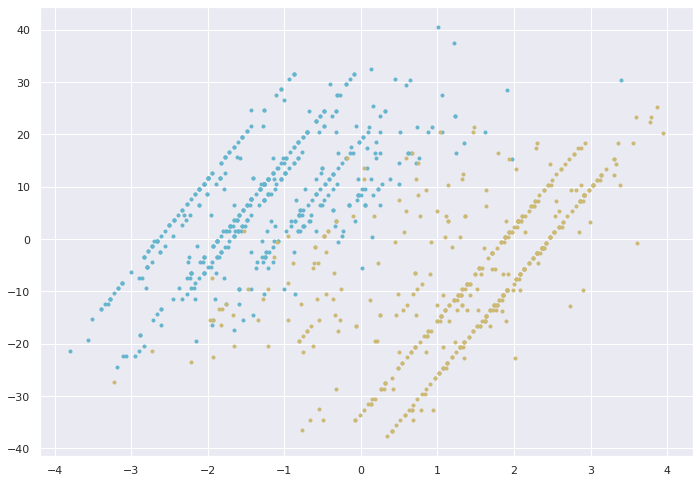

In [40]:
conf_mat = test_model(GaussianNB(), char, target, pca, show_plot=True)

In [41]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[403 113]
 [ 66 379]]
Precisión: 0.8137
AUC: 0.8163
F1-Scores: 0.809


In [42]:
conf_mat = test_model(GaussianNB(), red_char, target)

In [43]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[378 138]
 [ 70 375]]
Precisión: 0.7836
AUC: 0.7876
F1-Scores: 0.7829


La precisión no ha mejorado usando las características seleccionadas.

### Árbol de decisión (interpretable):


In [44]:
from sklearn.tree import DecisionTreeClassifier

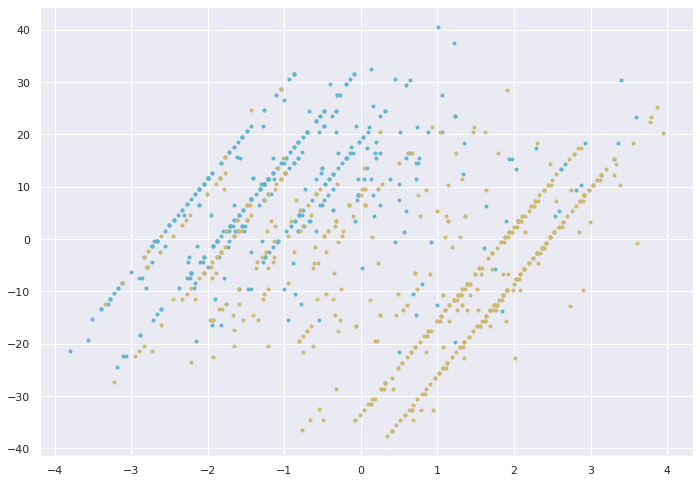

In [45]:
conf_mat = test_model(DecisionTreeClassifier(criterion='gini'), char, target, pca, show_plot=True)

In [46]:
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[414 102]
 [126 319]]
Precisión: 0.7627
AUC: 0.7596
F1-Scores: 0.7367


Ahora lo testamos para varias profundidades máximas distintas:

In [47]:
estimadores = [
               DecisionTreeClassifier(max_depth=None, random_state=1),
               DecisionTreeClassifier(max_depth=1, random_state=1),
               DecisionTreeClassifier(max_depth=2, random_state=1),
               DecisionTreeClassifier(max_depth=3, random_state=1),
               DecisionTreeClassifier(max_depth=4, random_state=1),
               DecisionTreeClassifier(max_depth=5, random_state=1)
]
nombres = [
           "Árbol completo",
           "Árbol p1",
           "Árbol p2",
           "Árbol p3",
           "Árbol p4",
           "Árbol p5"
]
result_arboles = test_todos(estimadores, nombres, char, target)

/home/alejandro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass criterion=gini as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [48]:
result_arboles.to_csv("arb_dec_comparados.csv")

In [49]:
#Visualizamos un árbol de profundidad 3 con 4/5 partes del dataset como entrenamiento
max_size = (np.size(char, axis=0)//5)*4
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree_clf.fit(char[0:max_size, :], target[0:max_size])

DecisionTreeClassifier(max_depth=3)

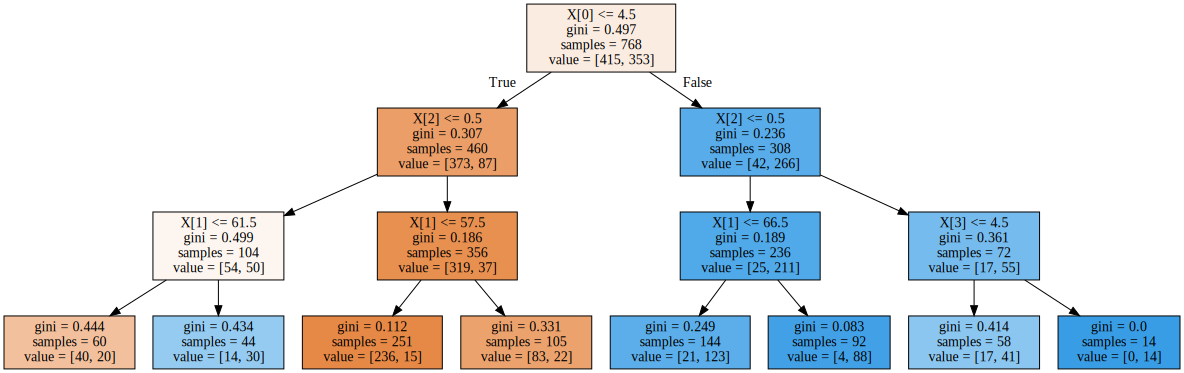

In [53]:
import graphviz
from sklearn.tree import export_graphviz
# DOT data
dot_data = export_graphviz(tree_clf, out_file=None, 
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph.render('decision_tree') 
graph

Visualizamos la clasificación hecha para una profundidad de 3 (la mejor obtenida)

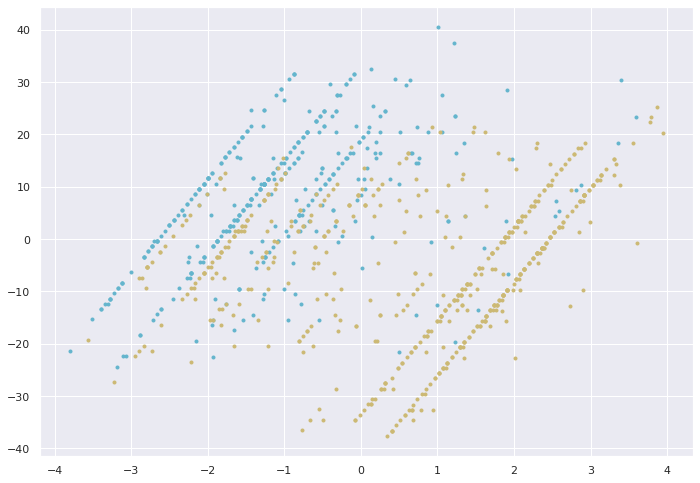

In [54]:
conf_mat = test_model(DecisionTreeClassifier(criterion='gini', max_depth=3), char, target, pca, show_plot=True)

In [55]:
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[465  51]
 [107 338]]
Precisión: 0.8356
AUC: 0.8304
F1-Scores: 0.8106


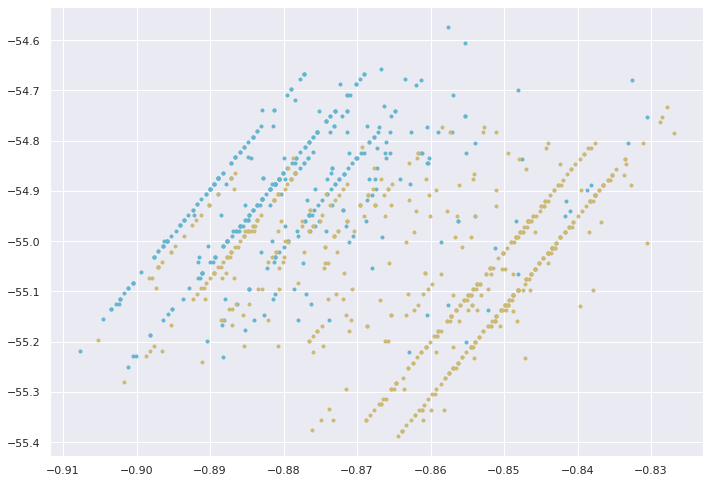

In [56]:
conf_mat = test_model(DecisionTreeClassifier(criterion='gini', max_depth=3), norm_char, target, pca, show_plot=True)

In [57]:
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[465  51]
 [107 338]]
Precisión: 0.8356
AUC: 0.8304
F1-Scores: 0.8106


In [58]:
conf_mat = test_model(DecisionTreeClassifier(criterion='gini', max_depth=3), red_char, target)

In [59]:
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[387 129]
 [ 67 378]]
Precisión: 0.796
AUC: 0.7997
F1-Scores: 0.7941


In [60]:
conf_mat = test_model(DecisionTreeClassifier(criterion='gini', max_depth=3), onehot_char, target)

In [61]:
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[416 100]
 [ 79 366]]
Precisión: 0.8137
AUC: 0.8143
F1-Scores: 0.8035


### **AdaBoost**

In [62]:
from sklearn.ensemble import AdaBoostClassifier

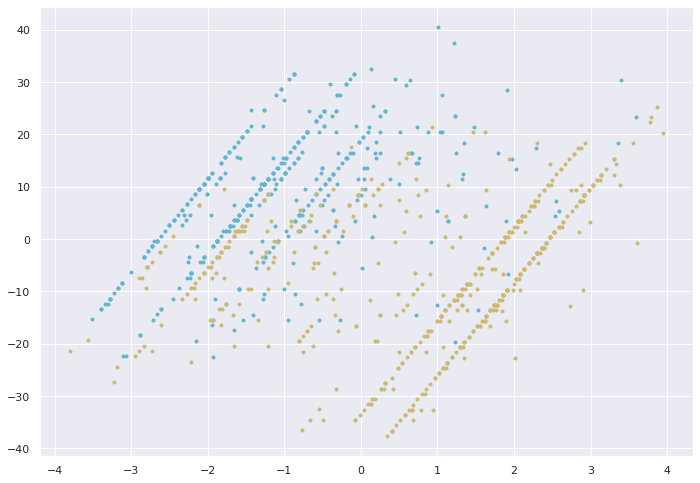

In [63]:
conf_mat = test_model(AdaBoostClassifier(learning_rate=1, n_estimators=5), char, target, pca, show_plot=True)

In [64]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[445  71]
 [ 97 348]]
Precisión: 0.8252
AUC: 0.8222
F1-Scores: 0.8056


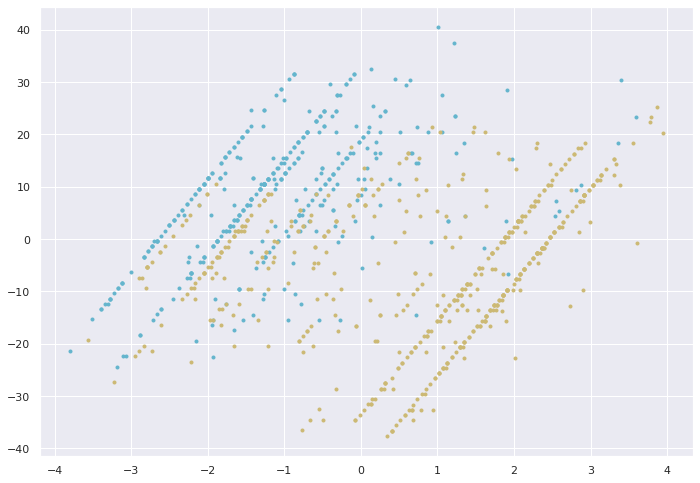

In [65]:
conf_mat = test_model(AdaBoostClassifier(learning_rate=0.1, n_estimators=30), char, target, pca, show_plot=True)

In [66]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[462  54]
 [102 343]]
Precisión: 0.8377
AUC: 0.8331
F1-Scores: 0.8147


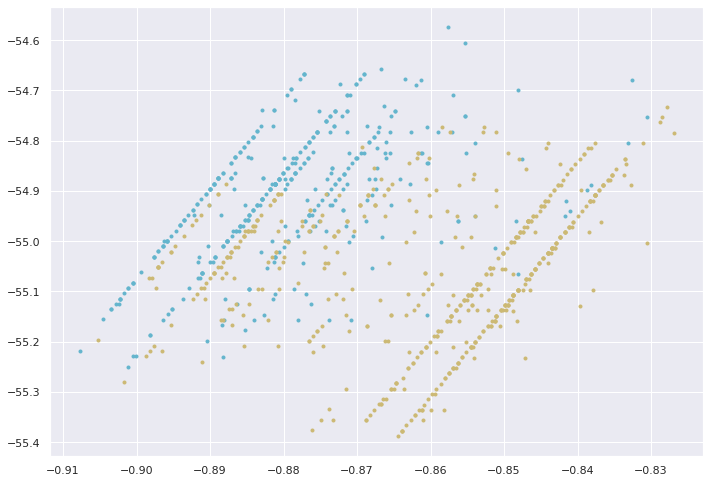

In [67]:
conf_mat = test_model(AdaBoostClassifier(learning_rate=0.1, n_estimators=30), norm_char, target, pca, show_plot=True)

In [68]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[462  54]
 [102 343]]
Precisión: 0.8377
AUC: 0.8331
F1-Scores: 0.8147


In [69]:
conf_mat = test_model(AdaBoostClassifier(learning_rate=0.1, n_estimators=30), red_char, target)

In [70]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[411 105]
 [ 83 362]]
Precisión: 0.8044
AUC: 0.805
F1-Scores: 0.7939


In [71]:
conf_mat = test_model(AdaBoostClassifier(learning_rate=0.1, n_estimators=30), onehot_char, target)

In [72]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[435  81]
 [101 344]]
Precisión: 0.8106
AUC: 0.808
F1-Scores: 0.7908


### Regresión Logística

In [73]:
from sklearn.linear_model import LogisticRegression

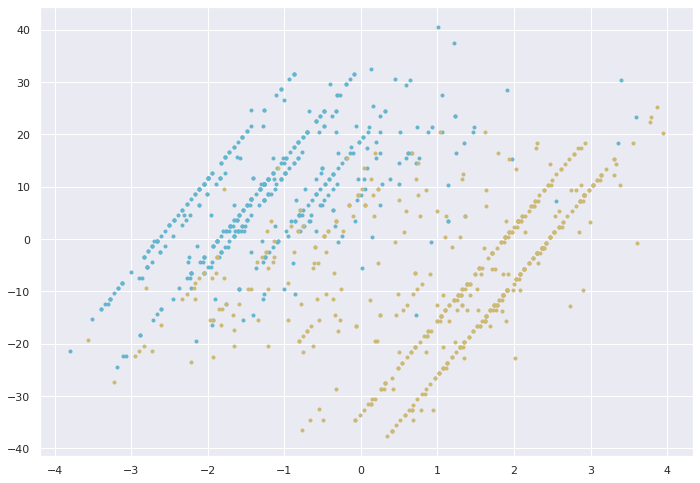

In [74]:
conf_mat = test_model(LogisticRegression(random_state=1, C=1), char, target, pca, show_plot=True)

In [75]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[424  92]
 [ 82 363]]
Precisión: 0.8189
AUC: 0.8187
F1-Scores: 0.8067


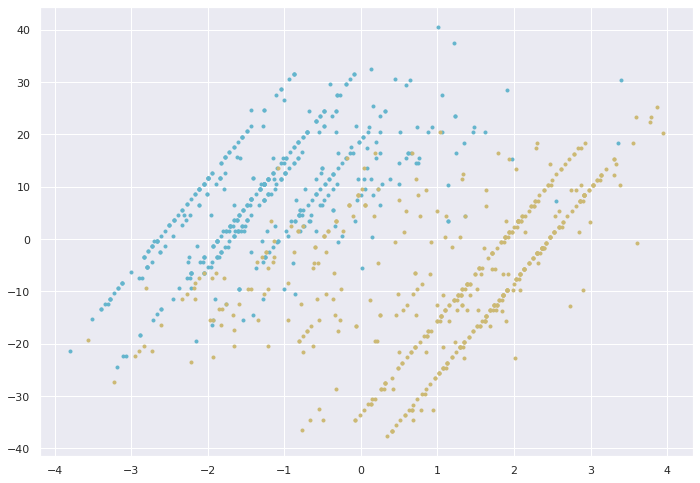

In [76]:
conf_mat = test_model(LogisticRegression(random_state=1, C=0.1), char, target, pca, show_plot=True)

In [77]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[424  92]
 [ 76 369]]
Precisión: 0.8252
AUC: 0.8255
F1-Scores: 0.8146


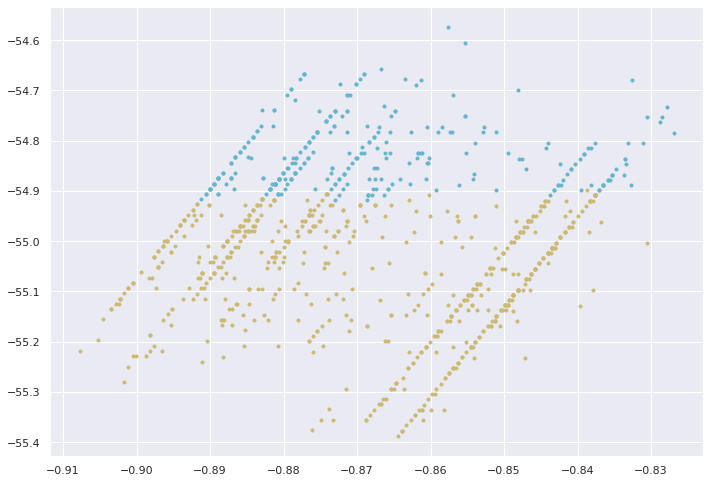

In [78]:
conf_mat = test_model(LogisticRegression(random_state=1, C=0.1), norm_char, target, pca, show_plot=True)

In [79]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[435  81]
 [226 219]]
Precisión: 0.6805
AUC: 0.6676
F1-Scores: 0.5879


In [80]:
conf_mat = test_model(LogisticRegression(random_state=1, C=0.1), red_char, target)

In [81]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[397 119]
 [ 77 368]]
Precisión: 0.796
AUC: 0.7982
F1-Scores: 0.7897


In [82]:
conf_mat = test_model(LogisticRegression(random_state=1, C=0.1), onehot_char, target)

In [83]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[427  89]
 [ 91 354]]
Precisión: 0.8127
AUC: 0.8115
F1-Scores: 0.7973


### Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

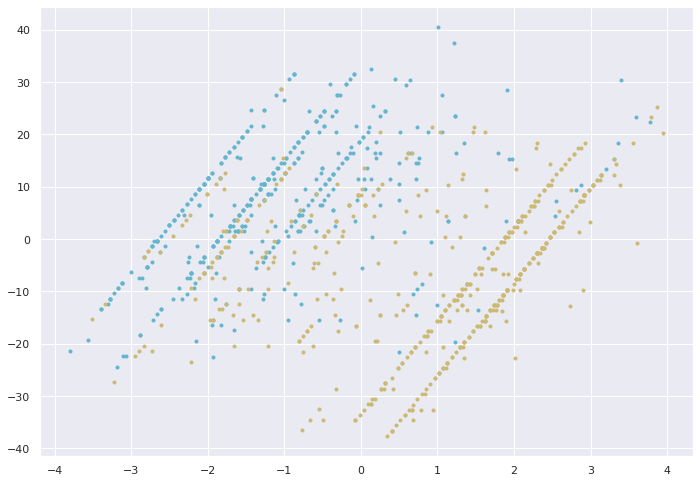

In [85]:
conf_mat = test_model(RandomForestClassifier(random_state=1), char, target, pca, show_plot=True)

In [86]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[417  99]
 [101 344]]
Precisión: 0.7919
AUC: 0.7906
F1-Scores: 0.7748


Ahora lo testamos para varias profundidades máximas distintas:

In [87]:
estimadores = [
               RandomForestClassifier(max_depth=None, random_state=1),
               RandomForestClassifier(max_depth=1, random_state=1),
               RandomForestClassifier(max_depth=2, random_state=1),
               RandomForestClassifier(max_depth=3, random_state=1),
               RandomForestClassifier(max_depth=4, random_state=1),
               RandomForestClassifier(max_depth=5, random_state=1),
               RandomForestClassifier(max_depth=6, random_state=1),
               RandomForestClassifier(max_depth=7, random_state=1)
]
nombres = [
           "Árboles completos",
           "Árboles p1",
           "Árboles p2",
           "Árboles p3",
           "Árboles p4",
           "Árboles p5",
           "Árboles p6",
           "Árboles p7"
]
result_arboles = test_todos(estimadores, nombres, char, target)

In [88]:
result_arboles.to_csv("random_forest_comparacion.csv")

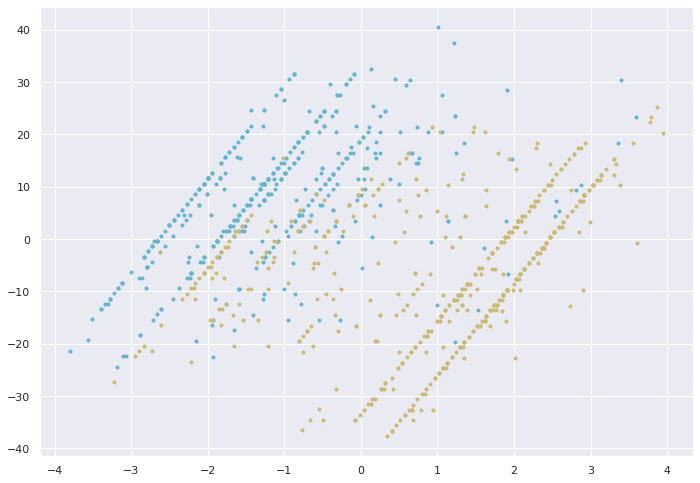

In [90]:
conf_mat = test_model(RandomForestClassifier(max_depth=4, random_state=1), char, target, pca, show_plot=True)

In [91]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[442  74]
 [ 80 365]]
Precisión: 0.8398
AUC: 0.8384
F1-Scores: 0.8258


In [92]:
conf_mat = test_model(RandomForestClassifier(max_depth=4, random_state=1), red_char, target)

In [93]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[402 114]
 [ 80 365]]
Precisión: 0.7981
AUC: 0.7996
F1-Scores: 0.79


In [94]:
conf_mat = test_model(RandomForestClassifier(max_depth=4, random_state=1), onehot_char, target)

In [95]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[424  92]
 [ 83 362]]
Precisión: 0.8179
AUC: 0.8176
F1-Scores: 0.8053


### k-NN

In [96]:
from sklearn.neighbors import KNeighborsClassifier

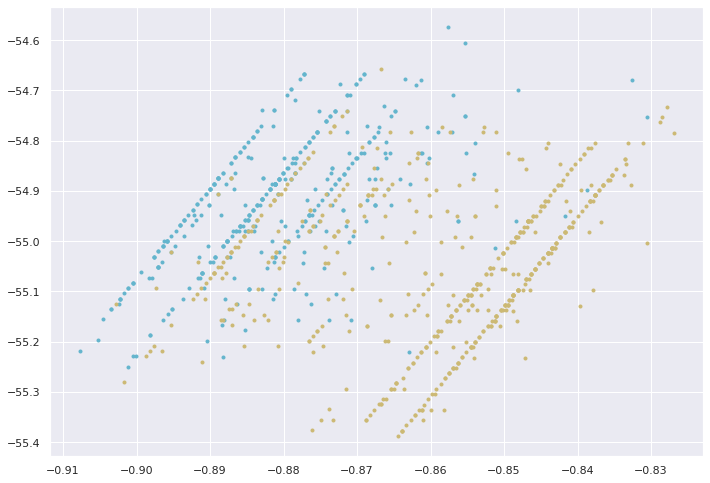

In [97]:
conf_mat = test_model(KNeighborsClassifier(5, metric='hamming', weights='uniform'), norm_char, target, pca, show_plot=True)

In [98]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[449  67]
 [114 331]]
Precisión: 0.8117
AUC: 0.807
F1-Scores: 0.7853


### Redes Neuronales

In [99]:
from sklearn.neural_network import MLPClassifier

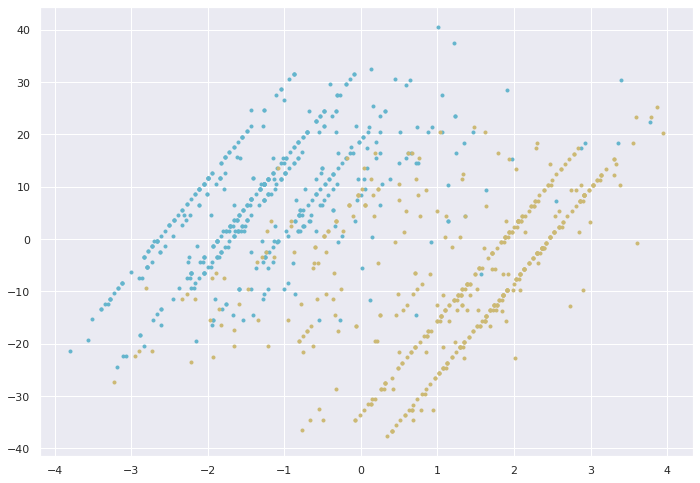

In [100]:
conf_mat = test_model(MLPClassifier(hidden_layer_sizes=(25, 3), max_iter=10000, random_state=1), char, target, pca, show_plot=True)

In [101]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[408 108]
 [ 70 375]]
Precisión: 0.8148
AUC: 0.8167
F1-Scores: 0.8082


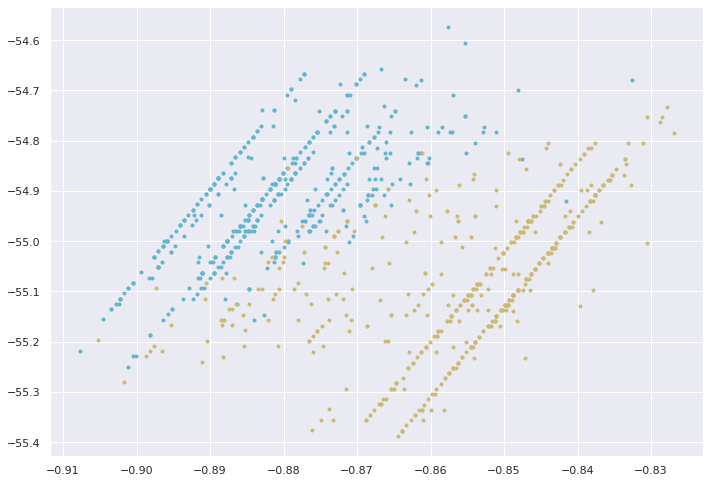

In [102]:
conf_mat = test_model(MLPClassifier(hidden_layer_sizes=(25, 3), max_iter=10000, random_state=1), norm_char, target, pca, show_plot=True)

In [103]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[412 104]
 [ 78 367]]
Precisión: 0.8106
AUC: 0.8116
F1-Scores: 0.8013


In [104]:
conf_mat = test_model(MLPClassifier(hidden_layer_sizes=(25, 3), max_iter=10000, random_state=1), red_char, target)

In [105]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[516   0]
 [445   0]]
Precisión: 0.5369
AUC: 0.5
F1-Scores: 0.0


In [106]:
conf_mat = test_model(MLPClassifier(hidden_layer_sizes=(25, 3), max_iter=10000, random_state=1), onehot_char, target)

In [107]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[415 101]
 [ 80 365]]
Precisión: 0.8117
AUC: 0.8122
F1-Scores: 0.8013


### SVM

In [108]:
from sklearn.svm import LinearSVC

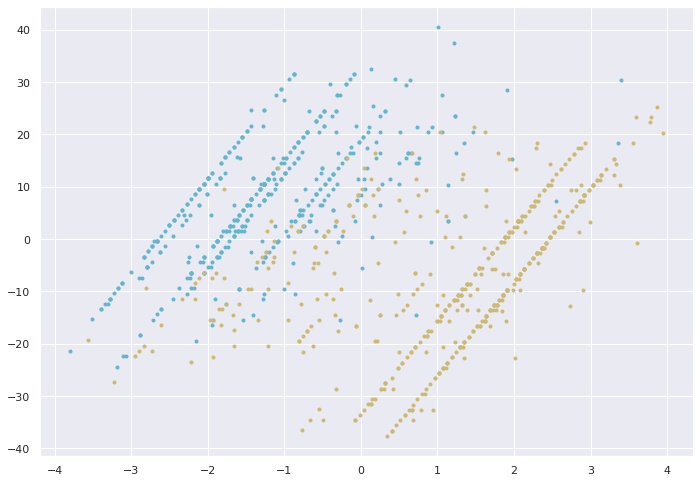

In [109]:
conf_mat = test_model(LinearSVC(random_state=1, max_iter=300000), char, target, pca, show_plot=True)

In [110]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[423  93]
 [ 77 368]]
Precisión: 0.8231
AUC: 0.8234
F1-Scores: 0.8124


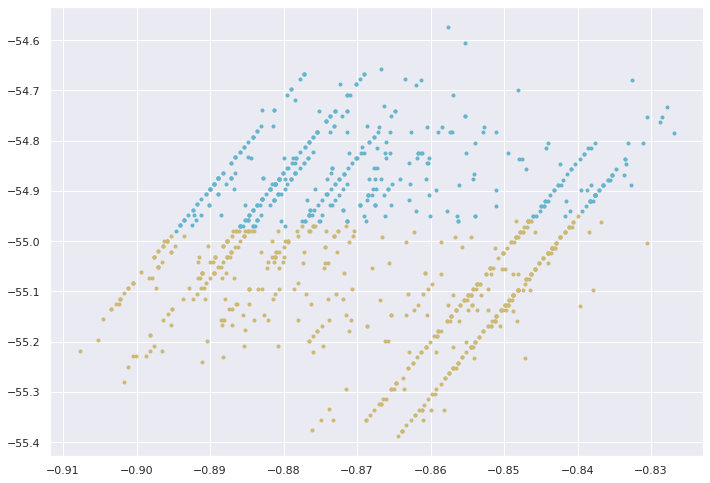

In [111]:
conf_mat = test_model(LinearSVC(random_state=1, C=0.1, max_iter=300000), norm_char, target, pca, show_plot=True)

In [112]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[376 140]
 [153 292]]
Precisión: 0.6951
AUC: 0.6924
F1-Scores: 0.6659


In [113]:
conf_mat = test_model(LinearSVC(random_state=1, max_iter=300000), red_char, target)

In [114]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[388 128]
 [ 69 376]]
Precisión: 0.795
AUC: 0.7984
F1-Scores: 0.7924


In [115]:
conf_mat = test_model(LinearSVC(random_state=1, max_iter=300000), onehot_char, target)

In [116]:
#[0,0]-->True Negatives
#[0,1]-->False Positives
#[1,0]-->False Negatives
#[1,1]-->True Positives
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[440  76]
 [ 99 346]]
Precisión: 0.8179
AUC: 0.8151
F1-Scores: 0.7982


### Multiclasificador por Votación

In [117]:
from sklearn.ensemble import VotingClassifier

In [118]:
clf1 = AdaBoostClassifier(learning_rate=0.1, n_estimators=30, random_state=1)
clf2 = LogisticRegression(random_state=1, C=0.1)
clf3 = RandomForestClassifier(max_depth=4, random_state=1)

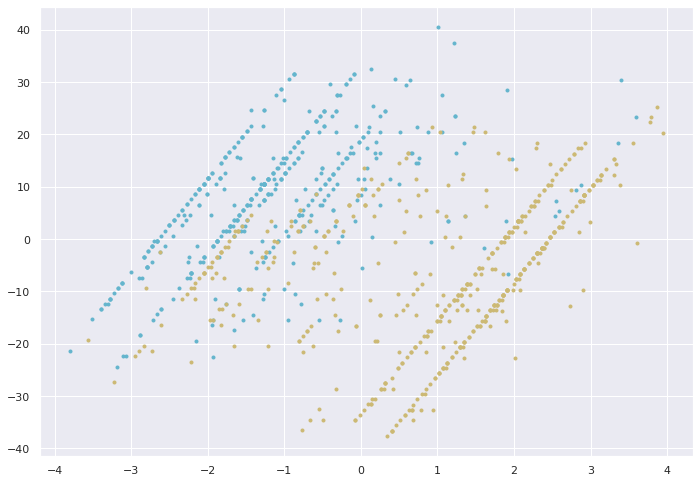

In [119]:
eclf = VotingClassifier( estimators=[('ad', clf1), ('lr', clf2), ('rf', clf3)] )
conf_mat = test_model(eclf, char, target, pca, show_plot=True)

In [120]:
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[445  71]
 [ 81 364]]
Precisión: 0.8418
AUC: 0.8402
F1-Scores: 0.8273


[[460  56]
 [ 95 350]]
Precisión: 0.8429
AUC: 0.839
F1-Scores: 0.8226


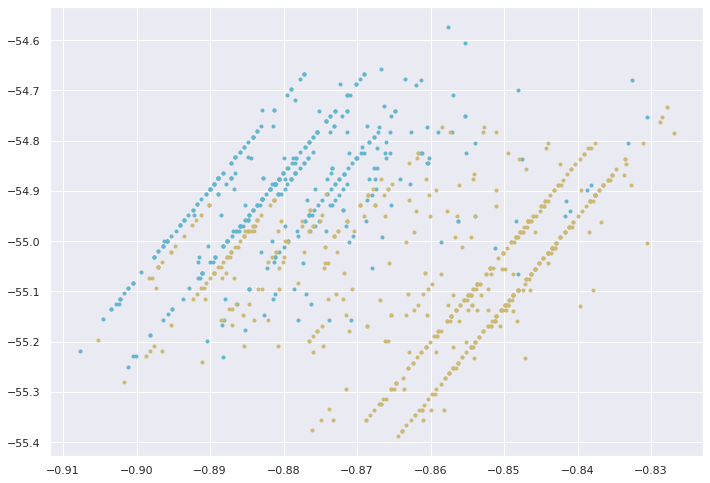

In [121]:
conf_mat = test_model(eclf, norm_char, target, pca, show_plot=True)
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

In [122]:
conf_mat = test_model(eclf, red_char, target)
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[405 111]
 [ 79 366]]
Precisión: 0.8023
AUC: 0.8037
F1-Scores: 0.7939


In [123]:
conf_mat = test_model(eclf, onehot_char, target)
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[424  92]
 [ 84 361]]
Precisión: 0.8169
AUC: 0.8165
F1-Scores: 0.804


## 3. Test completo de cada modelo

Vamos a ejecutar cada modelo de los elegidos una serie de veces y quedarnos con un valor medio para cada métrica de las que estamos utilizando (precisión, AUC y F1-score)

Vamos a probar los resultados de los siguientes modelos:  
- Árbol de decisión
- Random Forest
- AdaBoost
- Regresión Logística
- Red Neuronal
- SVM
- Multiclasificador por Votación

Testearemos los modelos elegidos con el dataset completo, con el dataset completo normalizado y con el dataset reducido por PCA.

In [124]:
main_seed = 1
n_reps = 5

nombres = [
              'Árbol de Decisión',
              'Random Forest',
              'AdaBoost',
              'Regresión Logística',
              'Red Neuronal',
              'SVM Lineal',
              'MultiClas por Votación'
      ]

#Se generan tantas semillas como veces se vayan a repetir las cuentas
np.random.seed(main_seed)
semillas = np.random.randint(0, 1000000, n_reps)  
#Se crea una dataframe con las dimensiones del resultado
resultados = pd.DataFrame(0, index=nombres, columns=['Precisión', 'AUC', 'F1-Score'])
resultados_norm = pd.DataFrame(0, index=nombres, columns=['Precisión', 'AUC', 'F1-Score'])
resultados_red = pd.DataFrame(0, index=nombres, columns=['Precisión', 'AUC', 'F1-Score'])

#Se repite el experimento varias veces
for sem in semillas:

  clf1 = RandomForestClassifier(random_state=sem, max_depth=4)
  clf2 = AdaBoostClassifier(learning_rate=0.1, n_estimators=30, random_state=sem)
  clf3 = LogisticRegression(random_state=sem, C=0.1)
  estimadores = [
                DecisionTreeClassifier(random_state=sem, max_depth=3),
                clf1,
                clf2,
                clf3,
                MLPClassifier(hidden_layer_sizes=(25, 3), max_iter=10000, random_state=sem),
                LinearSVC(random_state=sem, max_iter=300000),
                VotingClassifier([('rf', clf1), ('ab', clf2), ('lr', clf3)])
    ]
  #Sumamos el dataframe resultado al actual
  resultados += test_todos(estimadores, nombres, char, target) 
  resultados_norm += test_todos(estimadores, nombres, norm_char, target)
  resultados_red += test_todos(estimadores, nombres, red_char, target)

#Tras sumar todos los resultados, dividimos entre el número de repeticiones
resultados /= n_reps
resultados_norm /= n_reps
resultados_red /= n_reps

In [125]:
resultados.to_csv("resultados.csv")
resultados

,Precisión,AUC,F1-Score
Árbol de Decisión,0.83560,0.83040,0.81060
Random Forest,0.83496,0.83404,0.82176
AdaBoost,0.83770,0.83310,0.81470
Regresión Logística,0.82520,0.82550,0.81460
Red Neuronal,0.74672,0.74018,0.63172
SVM Lineal,0.82310,0.82340,0.81240
MultiClas por Votación,0.83808,0.83686,0.82430


In [126]:
resultados_norm.to_csv("resultados_norm.csv")
resultados_norm

,Precisión,AUC,F1-Score
Árbol de Decisión,0.83560,0.83040,0.81060
Random Forest,0.83496,0.83404,0.82176
AdaBoost,0.83770,0.83310,0.81470
Regresión Logística,0.68050,0.66760,0.58790
Red Neuronal,0.81520,0.81600,0.80558
SVM Lineal,0.76170,0.76080,0.74410
MultiClas por Votación,0.84080,0.83692,0.82028


In [127]:
resultados_red.to_csv("resultados_red.csv")
resultados_red

,Precisión,AUC,F1-Score
Árbol de Decisión,0.79600,0.79970,0.79410
Random Forest,0.79958,0.80114,0.79160
AdaBoost,0.80440,0.80500,0.79390
Regresión Logística,0.79600,0.79820,0.78970
Red Neuronal,0.74192,0.73614,0.62906
SVM Lineal,0.79500,0.79840,0.79240
MultiClas por Votación,0.80438,0.80556,0.79548


# 4. Procesado alternativo: codificación binaria

La mayor parte de las variables en este estudio no son cuantitativas sino, como ya se ha mencionado anteriormente, cualitivas. Esto hace que la segmentación espacial que llevan a cabo muchos de los algoritmos utilizados no tengan sentido, porque no existe ningún orden entre los valores de cada categoría. Como codificación alternativa se ha probado a transformar el valor de cada variable en un array binario (one-hot array) con el módulo OneHotEncoder de sklearn.

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

In [129]:
main_seed = 1
n_reps = 4

nombres = [
              'Árbol de Decisión',
              'Random Forest',
              'AdaBoost',
              'Regresión Logística',
              'Red Neuronal',
              'SVM Lineal',
              'MultiClas por Votación'
      ]

#Se generan tantas semillas como veces se vayan a repetir las cuentas
np.random.seed(main_seed)
semillas = np.random.randint(0, 1000000, n_reps)  
#Se crea una dataframe con las dimensiones del resultado
resultados_onehot = pd.DataFrame(0, index=nombres, columns=['Precisión', 'AUC', 'F1-Score'])

#Se repite el experimento varias veces
for sem in semillas:

  clf1 = RandomForestClassifier(random_state=sem, max_depth=4)
  clf2 = AdaBoostClassifier(learning_rate=0.1, n_estimators=30, random_state=sem)
  clf3 = LogisticRegression(random_state=sem, C=0.1)
  estimadores = [
                DecisionTreeClassifier(random_state=sem, max_depth=3),
                clf1,
                clf2,
                clf3,
                MLPClassifier(hidden_layer_sizes=(25, 3), max_iter=10000, random_state=sem),
                LinearSVC(random_state=sem, max_iter=300000),
                VotingClassifier([('rf', clf1), ('ab', clf2), ('lr', clf3)])
    ]
  #Sumamos el dataframe resultado al actual
  resultados_onehot += test_todos(estimadores, nombres, onehot_char, target) 

#Tras sumar todos los resultados, dividimos entre el número de repeticiones
resultados_onehot /= n_reps

In [130]:
resultados_onehot.to_csv("resultados_onehot.csv")
resultados_onehot

,Precisión,AUC,F1-Score
Árbol de Decisión,0.813700,0.814300,0.803500
Random Forest,0.820775,0.820875,0.809475
AdaBoost,0.810600,0.808000,0.790800
Regresión Logística,0.812700,0.811500,0.797300
Red Neuronal,0.807225,0.806350,0.792375
SVM Lineal,0.817900,0.815100,0.798200
MultiClas por Votación,0.817650,0.817250,0.804900


In [131]:
main_seed = 1
n_reps = 5

nombres = [
              'Árbol de Decisión',
              'Random Forest',
      ]

#Se generan tantas semillas como veces se vayan a repetir las cuentas
np.random.seed(main_seed)
semillas = np.random.randint(0, 1000000, n_reps)  
#Se crea una dataframe con las dimensiones del resultado
resultados_trees_onehot = pd.DataFrame(0, index=nombres, columns=['Precisión', 'AUC', 'F1-Score'])

#Se repite el experimento varias veces
for sem in semillas:
  estimadores = [
                DecisionTreeClassifier(random_state=sem, max_depth=3),
                RandomForestClassifier(random_state=sem, max_depth=4)
    ]
  #Sumamos el dataframe resultado al actual
  resultados_trees_onehot += test_todos(estimadores, nombres, onehot_char, target) 

#Tras sumar todos los resultados, dividimos entre el número de repeticiones
resultados_trees_onehot /= n_reps

In [132]:
resultados_trees_onehot.to_csv("resultados_trees_onehot.csv")
resultados_trees_onehot

,Precisión,AUC,F1-Score
Árbol de Decisión,0.81370,0.8143,0.80350
Random Forest,0.82062,0.8207,0.80926


In [133]:
#Visualizamos un árbol de profundidad 3 con 4/5 partes del dataset como entrenamiento
total_size = np.size(char, axis=0)
max_size = (total_size//5)*4
part_size = total_size-max_size
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=87)
tree_clf.fit(onehot_char[part_size:total_size, :], target[part_size:total_size])

DecisionTreeClassifier(max_depth=3, random_state=87)

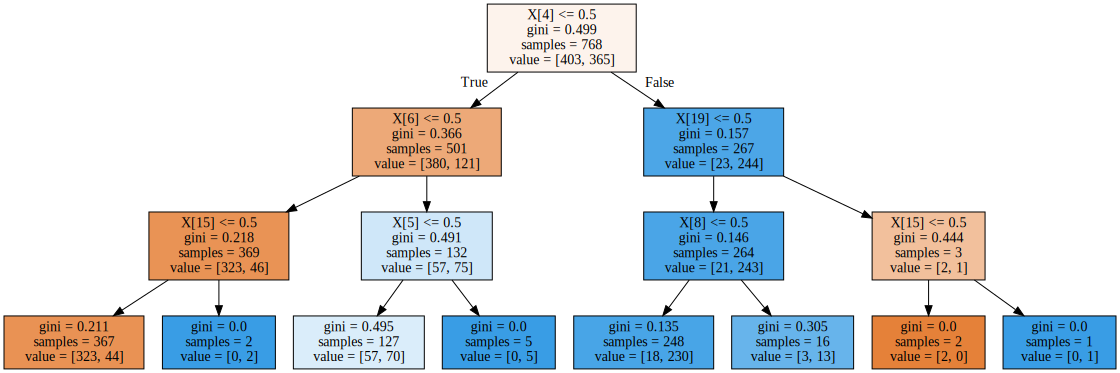

In [134]:
import graphviz
from sklearn.tree import export_graphviz
# DOT data
dot_data = export_graphviz(tree_clf, out_file=None, 
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph.render('decision_tree_oneshot') 
graph

In [135]:
conf_mat = test_model(tree_clf, onehot_char, target)
print(conf_mat)
print("Precisión:", prec_from_conf_mat(conf_mat))
print("AUC:", auc_from_conf_mat(conf_mat))
print("F1-Scores:", f1_from_conf_mat(conf_mat))

[[416 100]
 [ 79 366]]
Precisión: 0.8137
AUC: 0.8143
F1-Scores: 0.8035
